In [23]:
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers

def return_portfolios(expected_returns, cov_matrix):
    port_returns = []
    port_volatility = []
    stock_weights = []
    
    selected = (expected_returns.axes)[0]
    
    num_assets = len(selected) 
    num_portfolios = 5000
    
    for single_portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, expected_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    
    portfolio = {'Returns': port_returns,
                 'Volatility': port_volatility}
    
    for counter,symbol in enumerate(selected):
        portfolio[symbol +' Weight'] = [Weight[counter] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]
    
    df = df[column_order]
   
    return df
  
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.as_matrix())

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from rf import * #codecademy
import codecademylib3_seaborn #codecademy
import numpy as np

path='stock_data.csv'
path='stock_data_nvidia.csv'
path='stocks_nvidia_dexcom.csv'

stock_data = pd.read_csv(path)
selected=list(stock_data.columns[1:])

returns_quarterly = stock_data[selected].pct_change()
expected_returns = returns_quarterly.mean()
cov_quarterly = returns_quarterly.cov()

single_asset_std=np.sqrt(np.diagonal(cov_quarterly))
df = return_portfolios(expected_returns, cov_quarterly) 
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])

df.plot.scatter(x='Volatility', y='Returns', fontsize=12)
plt.plot(risks, returns, 'y-o')
plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=200)


if 'dexcom' in path:
  plt.axvline(single_asset_std[-1], color='black')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='black',s=200)
  plt.scatter(single_asset_std[-2],expected_returns[-2],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  nvidia_EF=pd.read_csv('./risks_returns_nvidia.csv')
  plt.plot(risks, returns, 'k-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  plt.plot(nvidia_EF['risks'],nvidia_EF['returns'], 'g-o')
elif 'nvidia' in path:
  plt.axvline(single_asset_std[-1], color='green')
  plt.scatter(single_asset_std[-1],expected_returns[-1],marker='X',color='green',s=200)
  original_EF=pd.read_csv('./risks_returns_original.csv')
  plt.plot(risks, returns, 'g-o')
  plt.plot(original_EF['risks'],original_EF['returns'], 'y-o')
  
plt.ylabel('Expected Returns',fontsize=14)
plt.xlabel('Volatility (Std. Deviation)',fontsize=14)
plt.title('Efficient Frontier', fontsize=24)
plt.show()

FileNotFoundError: [Errno 2] File stocks_nvidia_dexcom.csv does not exist: 'stocks_nvidia_dexcom.csv'

In [47]:
import bs4 as bs
import pickle
import requests
import pandas_datareader.data as web
from datetime import datetime
from pandas import DataFrame

def save_sp500_tickers():
    resp = requests.get("http://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    soup = bs.BeautifulSoup(resp.text, "lxml")
    table = soup.find("table", {"class": "wikitable sortable"})
    tickers = []
    for row in table.findAll("tr")[1:]:
        ticker = row.findAll("td")[0].text
        tickers.append(ticker[:-1])

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers, f)

    return tickers

DataFrame(save_sp500_tickers()).to_csv("SP500_Tickers.csv")
# dow30 = ["IBM", "V", "MRK", "PFE", "JNJ", "NKE", "DOW", "WMT", "DIS", "CSCO", "MCD", "XOM", "VZ", "GS", "MSFT", "CAT", "BA", "MMM", "CVX", "PG", "JPM", "AXP", "RTX", "TRV", "HD", "AAPL", "KO", "INTC", "UNH", "WBA"]

# def get_daily_prices():
#     tickers = dow30
#     prices = []
#     start_date = datetime(2019, 5, 20)
#     end_date = datetime(2020, 5, 20)
   
#     prices = web.DataReader(tickers, "yahoo", start_date, end_date)["Close"]

#     return prices

# get_daily_prices().to_csv("DOW30.csv")

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 5.02
Annualised Volatility: 1.66


Symbols      MMM   ABT  ABBV  ABMD  ACN  ATVI  ADBE   AMD   AAP   AES  ...  \
allocation  0.34  0.32  0.18  0.02  0.1  0.05  0.24  0.16  0.09  0.03  ...   

Symbols     WYNN   XEL   XRX  XLNX   XYL   YUM  ZBRA   ZBH  ZION   ZTS  
allocation  0.37  0.17  0.32  0.06  0.18  0.33  0.32  0.22  0.07  0.41  

[1 rows x 505 columns]
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.16
Annualised Volatility: 0.23


Symbols      MMM   ABT  ABBV  ABMD   ACN  ATVI  ADBE   AMD   AAP   AES  ...  \
allocation  0.24  0.03  0.31  0.01  0.16  0.03  0.21  0.09  0.24  0.32  ...   

Symbols     WYNN   XEL   XRX  XLNX   XYL   YUM  ZBRA   ZBH  ZION   ZTS  
allocation  0.39  0.39  0.34  0.35  0.14  0.15  0.34  0.11  0.13  0.25  

[1 rows x 505

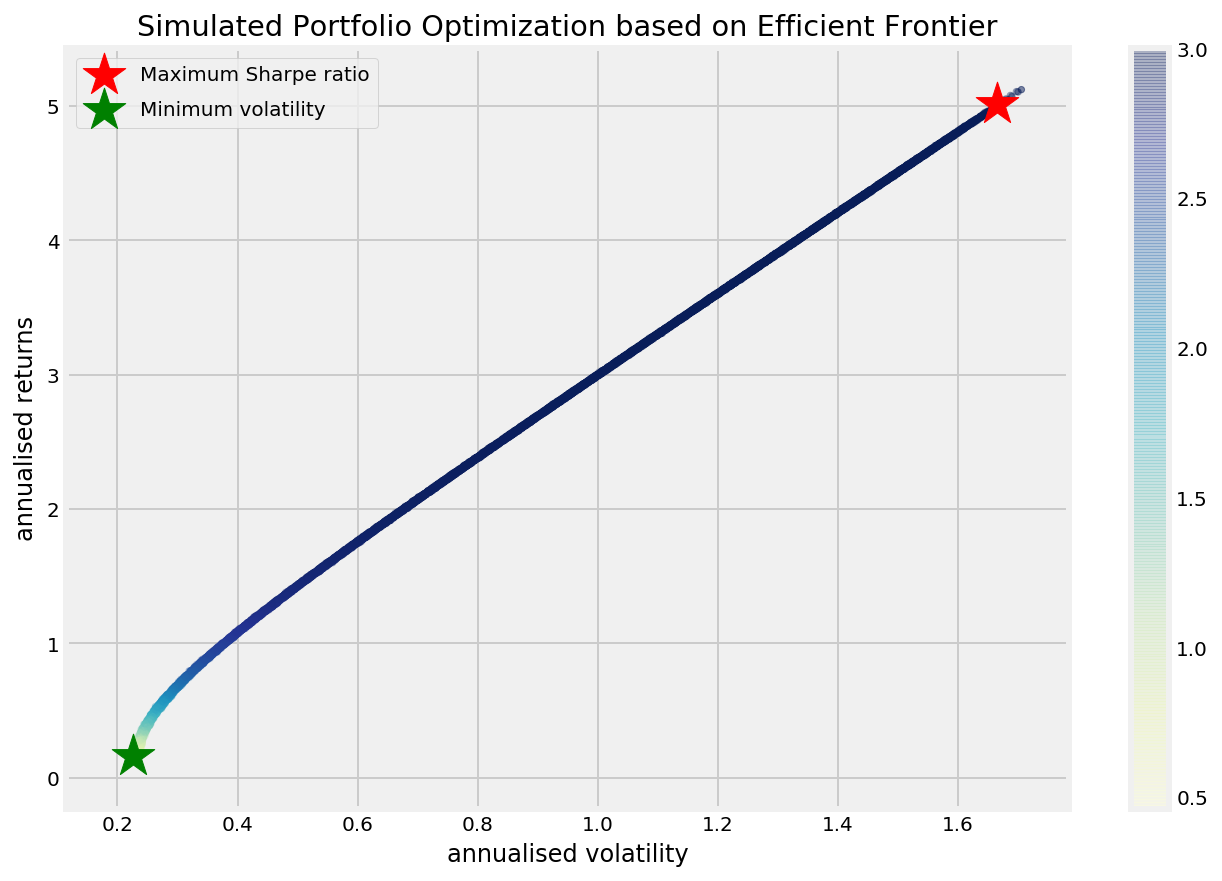

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime
import scipy.optimize as sco

plt.style.use("fivethirtyeight")
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = "retina"

stocks = pd.read_csv("SP500_Tickers.csv")
stocks = stocks.columns.tolist()
start_date = datetime(2007, 5, 27)
end_date = datetime(2020, 5, 26)
data = web.DataReader(stocks, "yahoo", start_date, end_date)["Close"]

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=["allocation"])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=["allocation"])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    max_sharpe_allocation.to_csv("max_sharpe_allocation.csv")
    min_vol_allocation.to_csv("min_vol_allocation.csv")
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap="YlGnBu", marker="o", s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker="*",color="r",s=500, label="Maximum Sharpe ratio")
    plt.scatter(sdp_min,rp_min,marker="*",color="g",s=500, label="Minimum volatility")
    plt.title("Simulated Portfolio Optimization based on Efficient Frontier")
    plt.xlabel("annualised volatility")
    plt.ylabel("annualised returns")
    plt.legend(labelspacing=0.8)
    
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)